<small><i>This notebook was put together by [Abel Meneses-Abad](http://www.menesesabad.com) for Paper *Paraphrase Beyond Sentence*. Source and license info is on [GitHub](https://github.com/sorice/2017paraphrasebsent/).</i></small>

# Classificating Paraphrase Sentences

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Loading Data

### Loading MSRP Corpus

In [3]:
#Load MSRP corpus
from scripts.datasets import load_msrpc
msrpc, index = load_msrpc('data/MSRPC-2004/msrpc.csv')
n_samples, n_features = msrpc.data.shape
print(n_samples,n_features)
x,y = msrpc.data, msrpc.target

5786 43


After some experiments we consider better to convert numpy.array in a pandas.DataFrame structure because can be useful to change *Nan* values by the median or mean of the column when the value is, this kind of operation with np is not possible (np.where and pd.where are differents).

In [4]:
df = pd.DataFrame(msrpc.data, columns=msrpc.feature_names, index=index)
df.values.shape, y.shape

((5786, 43), (5786,))

## Data preprocessing

### Missing NaN Values

Dealing with missing data. The Imputer method proposed in 03.4 change the shape of x.

In [5]:
df.replace(np.nan, df.mean(), inplace=True)
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

,yule_distance
16,NaN
35,NaN
176,NaN
217,NaN
228,NaN
...,...
5651,NaN
5730,NaN
5759,NaN
5763,NaN


### Handling Inf & -Inf Values

Using the results of 03.4 notebook.

In [6]:
is_inf = df.yule_distance == np.inf 
is_ninf = df.yule_distance == -np.inf
yule_mean = df.yule_distance[~is_inf & ~is_ninf].mean()
print(yule_mean)
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask] = yule_mean
df.replace([np.inf, -np.inf], yule_mean, inplace=True)

1.2699328823974734


In [7]:
col_mask=df.isnull().any(axis=0) 
row_mask=df.isnull().any(axis=1)
df.loc[row_mask,col_mask]

""


### Scaling Values

In [8]:
x = df

#Scaling
from sklearn.preprocessing import scale
Xs = scale(x,with_mean=True,with_std=True,axis=0)

#Multivariate data outliers handling not implemented yet.

#Partitioning data into test and train subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=4)

#Stratified Kfold not implemented yet.

## Clasification

multi_class = 'ovr' is set for this problem where there are only two binary classes.

In [9]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=200, n_jobs=4, multi_class='ovr')

#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

## Metrics Evaluation

In [10]:
from sklearn import metrics

# STEP 3: make predictions on the testing set
y_pred = logreg.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
metrics.accuracy_score(y_test, y_pred)

0.755184331797235

In [11]:
metrics.f1_score(y_test, y_pred)

0.8273059731816336

In [12]:
metrics.roc_curve(y_test, y_pred)

(array([0.        , 0.46823956, 1.        ]),
 array([0.        , 0.85907173, 1.        ]),
 array([2, 1, 0]))

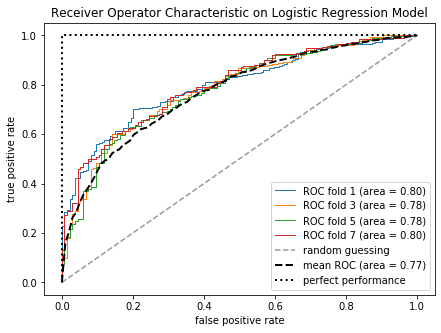

In [13]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc

X_train2 = X_train#[:, [4, 14]] #Modified this to have feature selection

skfolds = StratifiedKFold(n_splits=10)

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1, max_iter=200, n_jobs=4, multi_class='ovr'))])

for i, (train, test) in enumerate(skfolds.split(X_train2,y_train)):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic on Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()

In [14]:
from sklearn.svm import SVC # "Support Vector Classifier"

# instantiate the model (using the default parameters)
clf = SVC(kernel='linear')

#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
clf.fit(X_train, y_train)

# STEP 3: make predictions on the testing set
y_pred = clf.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred))

0.7672811059907834
0.8376205787781351


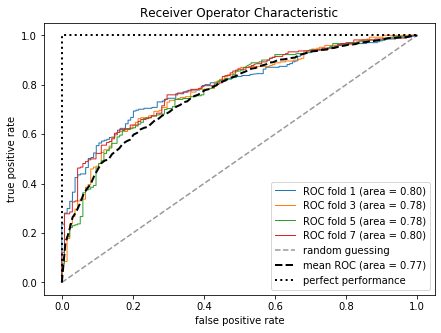

In [15]:
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', SVC(kernel='linear', probability=True))])

for i, (train, test) in enumerate(skfolds.split(X_train2,y_train)):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10 # of kfolds
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the default parameters)
knn = KNeighborsClassifier(n_neighbors=30)

#New data after Feature Selection
#Xs_train, ys_train, Xs_test, ys_test = get_train_test(x_n,Y)

# fit the model with data
knn.fit(X_train, y_train)

# STEP 3: make predictions on the testing set
y_pred = knn.predict(X_test)

# compare actual response values (y_test) with predicted response values (y_pred)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred))

0.7321428571428571
0.8149621965777955


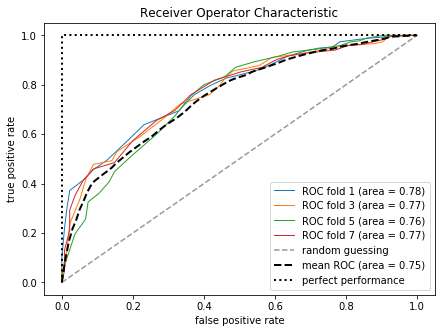

In [17]:
from sklearn.neighbors import KNeighborsClassifier

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', KNeighborsClassifier(n_neighbors=30))])

for i, (train, test) in enumerate(skfolds.split(X_train2,y_train)):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if i in [0,2,4,6]:
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, ls=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

# Conclusions

The comparation between *Logistic Regression* and *Support Vector Classifier* shows that accuracy & F-measure is higer in SVM. ROC is the same in both.

Based on this analysis SVM is better but, the recursive experimentation shows that the models are uncapable to capture more than 77% of the cases. The only possible change is to generate new and different features of our objects.

# Recomendations

* Read more about AUC: [ROC sklearn](file:///usr/share/doc/python-sklearn-doc/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc), and try to understand why so many studies consider better this metric over ROC.
* Read the rest of [sklearn classification metrics](file:///usr/share/doc/python-sklearn-doc/stable/modules/model_evaluation.html#classification-metrics)

In [19]:
#saving obtained clean data for future notebooks
import pickle
data = [X_train, X_test, y_train, y_test]
pickle.dump(data, open('data/cleaned-split-data.pkl', 'wb'))
pickle.dump(logreg, open('data/logreg_model.pkl', 'wb')) 

# Questions
* Test more metrics contained in sklearn: [cross validation metrics](file:///usr/share/doc/python-sklearn-doc/stable/modules/cross_validation.html#computing-cross-validated-metrics)
* Calc AUC in the same data with the same model.
* Test another sklearn supervised models, like Naive Bayes, Decision Trees, and analyse the results.
* Try an ensemble method and see if you can improved the results of accuracy or F measure. 

# References and Resources

* Sebastian Raschka, Book "Python Machine Learning". Packt Publishing, 2015.
<a id='Raschka2015'></a>

* Justin Markham, online course [Introduction to machine learning with scikit-learn](http://nbviewer.ipython.org/github/justmarkham/scikit-learn-videos/tree/master/), first edition 2015.

__Notes:__ Some ideas of this notebook are taken from Raschka book, but the codes have been updated for current versions of sklearn. 